In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import polyphase as phase
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

3-dimensional grid generated at 0.04s
Energy computed at 0.06s
Making energy manifold a paraboloid with 1x padding of 0.12 maximum energy
Energy is corrected at 0.20s
Convexhull is computed at 0.20s
Using 1.43E-01 as a threshold for Laplacian of a simplex
Total of 1 simplices in the convex hull
Simplices are labelled at 0.20s
Labels are lifted at 0.20s
Total 0/1 coplanar simplices
Computation took 0.20s


<IPython.core.display.Javascript object>


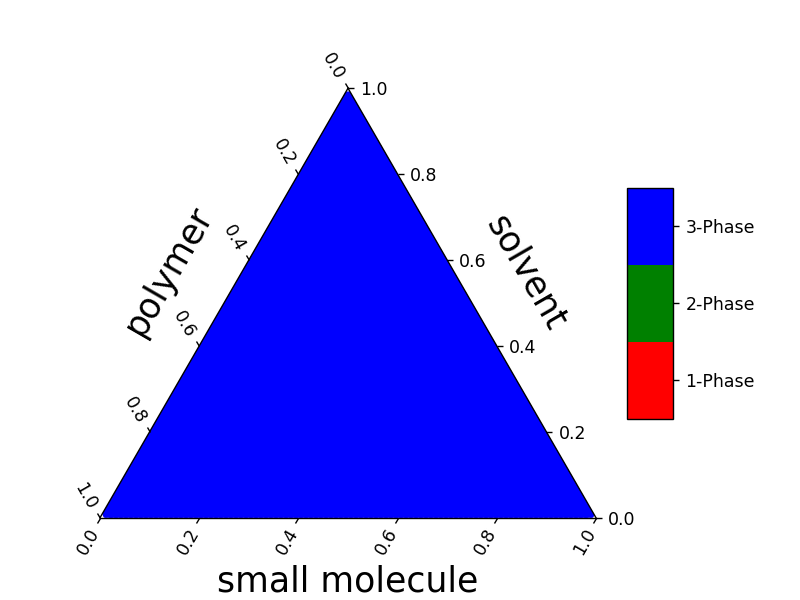

In [29]:
M = [5,5,1]
chi = [1, 0.5, 0.5]
#chi = [1, 0.5, 1]

configuration = {'M':M, 'chi':chi}

meshsize = 100
kwargs = {
    'flag_refine_simplices':True,
    'flag_lift_label': True,
    'use_weighted_delaunay': False,
    'flag_remove_collinear' : False, 
    'beta':1e-4, # not used 
    'flag_make_energy_paraboloid': True, 
    'pad_energy': 1,
    'flag_lift_purecomp_energy': False,
    'threshold_type':'uniform',
    'thresh_scale':0.1*meshsize,
    'lift_grid_size':meshsize,
    'verbose' : True
 }
out = phase.serialcompute(configuration,meshsize, **kwargs) 
grid = out['grid']
num_comps = out['num_comps']
simplices = out['simplices']
energy = out['energy']

phase.plot_lifted_label_ternary(out['output'])
plt.show()

Angle at vertex 0 is nan degrees
Angle at vertex 1 is 179.96 degrees
Angle at vertex 2 is nan degrees


<IPython.core.display.Javascript object>


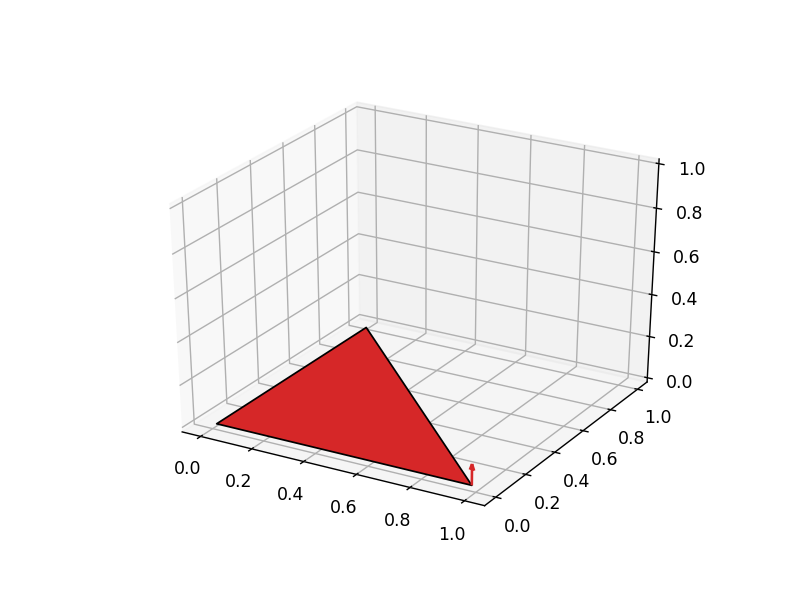

In [34]:
test = phase.TestAngles(out,phase=3,**kwargs)
test_out = test.get_angles(use_findiff=True)
for key, value in test_out['thetas'].items():
    print('Angle at vertex {} is {:.2f} degrees'.format(key, value[2]))

fig = test.visualize(required=[2])
plt.show()

In [31]:
MIN_POINT_PRECISION = 1e-8
def is_boundary_point(point):
    if np.isclose(point, MIN_POINT_PRECISION).any():
        return True
    else:
        return False

<IPython.core.display.Javascript object>


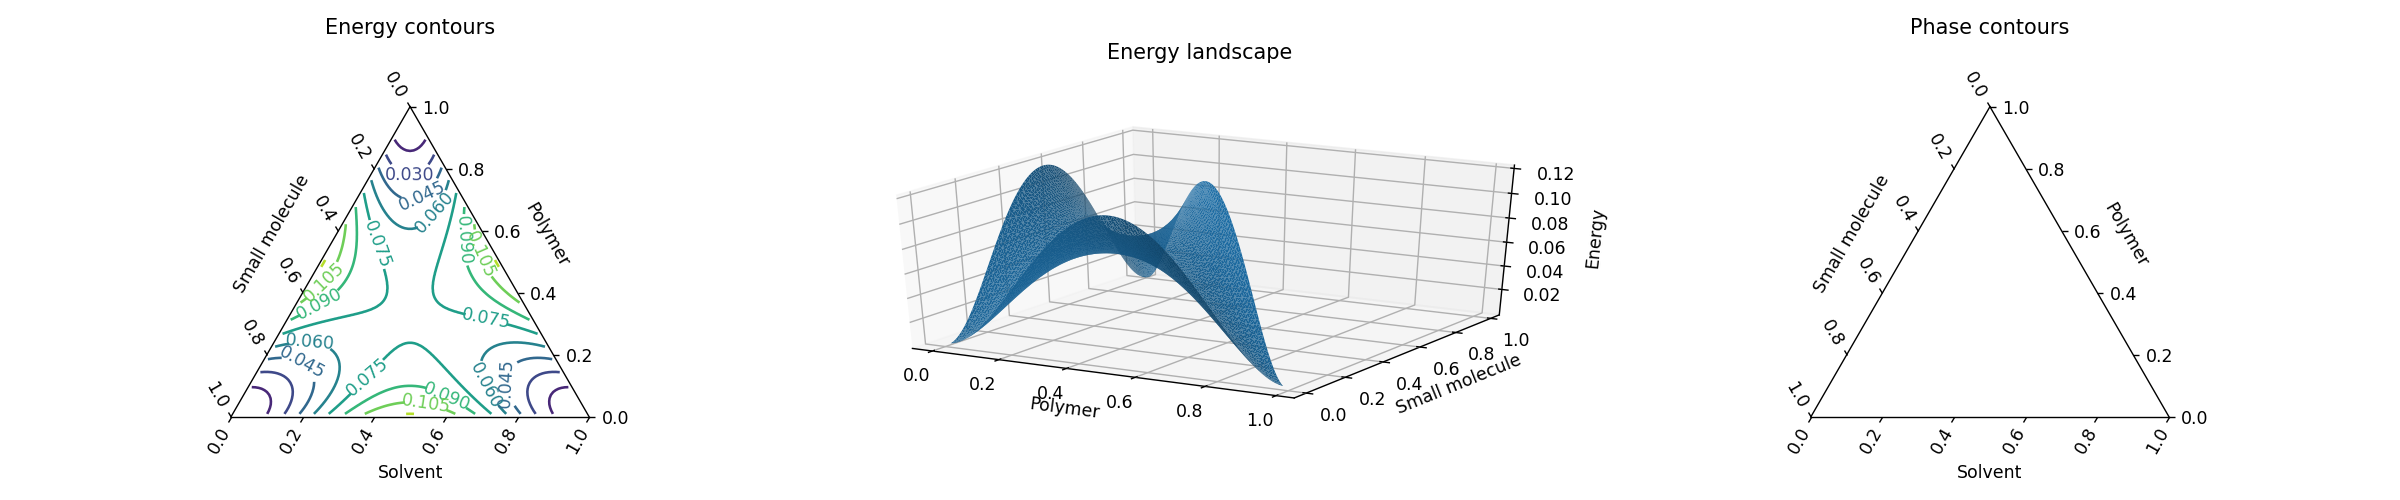

In [32]:
# Mesh size vs Energy surface
def makeAxis(title, tickangle):
    return {
      'title': title,
      'titlefont': { 'size': 20 },
      'tickangle': tickangle,
      'tickfont': { 'size': 15 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

def plotly_ternary_surface(grid, energy, num_comps):
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': "ternary"}, {'is_3d': True}]], 
                    subplot_titles=('Phase diagram','Energy landscape'),
                    print_grid=False)
    
    fig_00 = ff.create_ternary_contour(grid, num_comps,
                                    pole_labels=['polymer', 'SM', 'solvent'],
                                    interp_mode='cartesian',
                                    ncontours=3,
                                    coloring='lines')
    
    for i in fig_00.data:
        fig.append_trace(i, row=1, col=1)
        
    boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
    x, y, z = grid[0,~boundary_points], grid[1,~boundary_points], energy[~boundary_points]
    fig_01 = go.Mesh3d(x=x, y=y, z=z, color='blue')
    fig.append_trace(fig_01,row=1, col=2)
    fig.update_layout(scene1 = dict(xaxis_title='polymer',yaxis_title='SM',zaxis_title='Energy',aspectmode='cube'))

    fig.update_layout(template='plotly_white')
    #fig.update_layout(showlegend=False)
    fig.update_layout({'ternary': {'sum': 100,
                                   'aaxis': makeAxis('Polymer', 0),
                                   'baxis': makeAxis('<br>Small Molecule', 45),
                                   'caxis': makeAxis('<br>Solvent', -45)}
                      })
    fig.layout.annotations[0].update(x=0.025)
    fig.layout.annotations[1].update(x=0.65)
    
    return fig


def plt_ternary_surface(grid, energy, num_comps):
    fig = plt.figure(figsize=(3*4*1.6,4))
    ax1 = fig.add_subplot(1,3,2, projection='3d')
    ax1.plot_trisurf(grid[0,:], grid[1,:], energy, linewidth=0.01, antialiased=True)
    ax1.set_xlabel('Polymer')
    ax1.set_ylabel('Small molecule')
    ax1.set_zlabel('Energy')
    ax1.set_title('Energy landscape', pad=42)
    
    ax2 = fig.add_subplot(1, 3, 1, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], energy)
    ax2.set_title("Energy contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    ax2 = fig.add_subplot(1, 3, 3, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], num_comps)
    ax2.set_title("Phase contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    plt.tight_layout()
    return

labels = out['output'].loc['label',:].to_numpy()
boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
plt_ternary_surface(grid[:,~boundary_points], energy[~boundary_points], labels[~boundary_points])
#plt.savefig('../figures/notebooks/{}.png'.format(m), dpi=500, bbox_inches='tight')
plt.show()

# 3. Common tangent test
There's a chance that this would not work because of [sub-derivative of a convex functions](https://en.wikipedia.org/wiki/Subderivative). So not being able to match the local derivatives at any tangent plane is fine because you're working with a discrete surface approximation of the energy landscape.

In [6]:
CHI = phase._utri2mat(configuration['chi'],3)
def threecomp_gradphi(x, beta=0):
    dEdx1 = (1/M[0])*(1+np.log(x[0])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] +\
    CHI[0,2] - 2*CHI[0,2]*x[0] - CHI[0,2]*x[1] - CHI[1,2]*x[1] + beta*((1/x[2]**2) - (1/x[0]**2))
    
    dEdx2 = (1/M[1])*(1+np.log(x[1])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] -\
    CHI[0,2]*x[0] + CHI[1,2] - 2*CHI[1,2]*x[1]  - CHI[1,2]*x[0]+ beta*((1/x[2]**2) - (1/x[1]**2))
    
    return [dEdx1, dEdx2]

In [7]:
import matplotlib.tri as mtri

class CentralDifference:
    """Compute central difference gradinet of energy
    Works only for a 3-dimensional grid or a ternary system
    """
    def __init__(self, grid, energy):
        triang = mtri.Triangulation(grid[0,:], grid[1,:])
        self.interp_lin = mtri.LinearTriInterpolator(triang, energy)

    def __call__(self,x,y, h = 1e-3):
        """
        x,y : coordinates (float)
        h   : gridspacing (float)

        """
        f_right = self.interp_lin(x+h,y).data.squeeze()
        f_left = self.interp_lin(x-h,y).data.squeeze()
        df_dx = (f_right - f_left)/2*h
        f_right = self.interp_lin(x,y+h).data.squeeze()
        f_left = self.interp_lin(x,y-h).data.squeeze()
        df_dy = (f_right - f_left)/2*h
        
        return [df_dx, df_dy]
    
    def plot_interpolated_energy(self):
        xi, yi = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
        z = self.interp_lin(xi, yi)
        fig, ax = plt.subplots()
        ax.contourf(xi, yi, z)
        plt.show()

delta = np.linalg.norm(grid[:2,0] - grid[:2,1])
cd = CentralDifference(grid, energy)    
df = np.asarray([cd(x,y, h = delta) for x,y in grid[:-1,:].T])

<IPython.core.display.Javascript object>


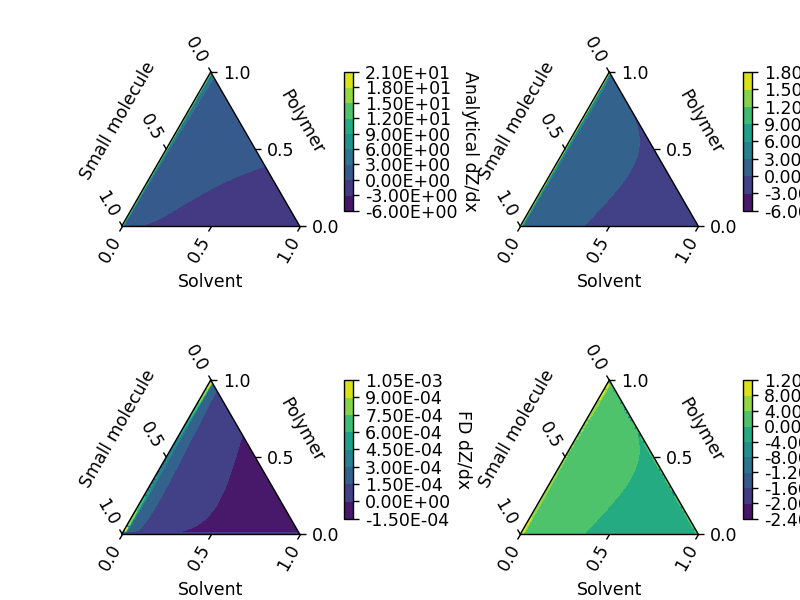

In [8]:
# Compare two gradient fields

def plot_gradient_field(grid, gradient, ax):
    fig = plt.gcf()
    cs = ax.tricontourf(grid[0,:], grid[1,:], grid[2,:], gradient)
    cax = ax.inset_axes([1.25, 0.1, 0.05, 0.9], transform=ax.transAxes)
    cbar = fig.colorbar(cs, cax=cax)
    cbar.ax.set_yticklabels(["{:.2E}".format(i) for i in cbar.get_ticks()])
    
    ax.set_tlabel('Polymer')
    ax.set_llabel('Small molecule')
    ax.set_rlabel('Solvent')

    ax.taxis.set_label_position('tick1')
    ax.laxis.set_label_position('tick1')
    ax.raxis.set_label_position('tick1')

    return ax, cbar

fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=0.8)

grad = np.asarray([threecomp_gradphi(x) for x in grid.T])

ax = fig.add_subplot(2,2,1,projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,0], ax)
cbar.set_label('Analytical dZ/dx', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,2,projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,1], ax)
cbar.set_label('Analytical dZ/dy', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,3,projection='ternary')
ax,cbar = plot_gradient_field(grid, np.nan_to_num(df[:,0]), ax)
cbar.set_label('FD dZ/dx', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,4,projection='ternary')
ax,cbar = plot_gradient_field(grid,np.nan_to_num(df[:,1]), ax)
cbar.set_label('FD dZ/dy', rotation=270, va='baseline')
plt.show()

Facet normal vs Plane points normal angle : 180.00
Angle at vertex 0 is 159.93 degrees
Angle at vertex 1 is 159.93 degrees
Angle at vertex 2 is 159.93 degrees


<IPython.core.display.Javascript object>


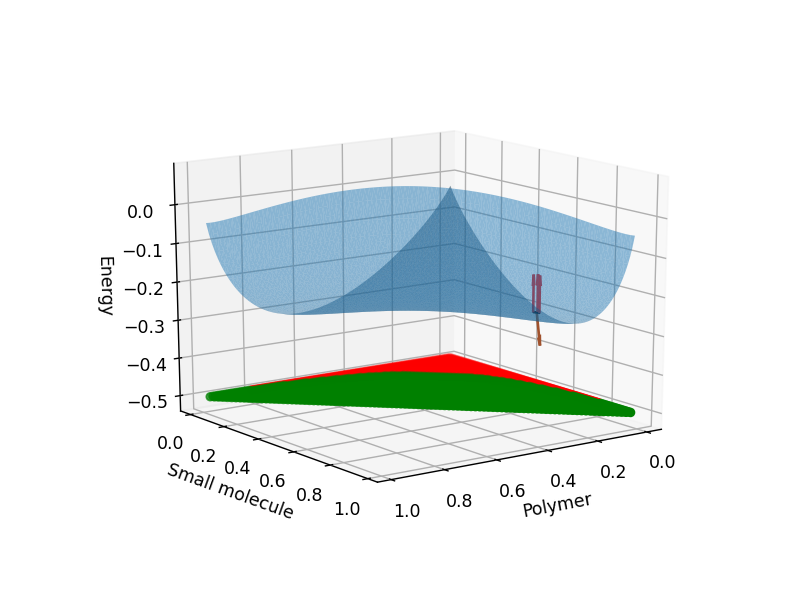

In [9]:
from sympy import Plane, Point3D, Line3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import ScalarMappable
from matplotlib import colors
from collections import Counter
import pdb

class TestAngles:
    def __init__(self, out, phase=2, **kwargs):
        """ Perform a test to compute angles of tangent planes at vertices to convex combination of points
        Test takes the out from polyphase.compute or polyphase.serialcompute and the same kwargs
        """
        self.grid = out['grid']
        self.num_comps = out['num_comps']
        self.simplices = out['simplices']
        self.energy = out['energy']
        self.X = out['output']
        self.out_ = out
        
        self.phase = phase
        self.beta = kwargs['beta']
        self.__dict__.update(kwargs)
        self.get_random_simplex()
        
    def get_random_simplex(self):
        phase_simplices_ids = np.where(np.asarray(self.num_comps)==self.phase)[0]
        self.rnd_simplex_indx = np.random.choice(phase_simplices_ids,1)
        self.rnd_simplex = self.simplices[self.rnd_simplex_indx].squeeze()
        self.vertices = self.X.iloc[:3,self.rnd_simplex].to_numpy().T
        self.parametric_points = np.hstack((self.vertices[:,:2],
                                            self.energy[self.rnd_simplex].reshape(-1,1))).tolist()
    
    def get_angles(self,use_findiff=True, **kwargs):
        """Compute angles between tangent planes at the simplex vertices and facet normal
        
        Facet normal can be compute by generating a plane equation or using the hull facet equations
        from `out_[hull].equations`. 
        
        use_findiff trigger the gradient computation using central difference of an interpolated energy
        see `class::CentralDifference` for more details
         
         
        returns dictonary of dictonaries with the following keys:
        'facet_normal' : facet normal of simplex from the convexhull
        'thetas'       : dictonary with vertices named in numeric keys (0,1,2) with each numeric key
                         containing the tuple (simplex id, normal to the tangent plane, angle with facet normal)
                         
        'gradients'    : dictonary with vertices named in numeric keys (0,1,2) with each numeric key
                         containing the tuple (df_dx, df_dy)
        """
        
        self.plane_points = Plane(self.parametric_points[0], self.parametric_points[1],
                             self.parametric_points[2])
        all_facet_equations = self.out_['hull'].equations[~self.out_['upper_hull']]
        facet_equation = all_facet_equations[self.rnd_simplex_indx].squeeze()
        self.facet_normal = facet_equation[:-1]
        point_plane_normal = np.asarray([float(x) for x in self.plane_points.normal_vector])
        print('Facet normal vs Plane points normal angle : {:.2f}'.format(self._angle_between_vectors(self.facet_normal,
                                                                                                      point_plane_normal)))
        if use_findiff:
            delta = np.linalg.norm(self.grid[:2,0] - self.grid[:2,1])
            cd = CentralDifference(self.grid, self.energy)    
            df = np.asarray([cd(x,y, h = delta) for x,y in self.grid[:-1,:].T])
        
        thetas = {}
        gradients = {}
        for i, (v,e) in enumerate(zip(self.vertices,
                                      self.energy[self.rnd_simplex])):
            x1,x2,_ = v
            p = Point3D(x1, x2, e)
            
            if not use_findiff:
                dx,dy = threecomp_gradphi(v, beta=self.beta)
            else:
                dx = df[self.rnd_simplex[i],0]
                dy = df[self.rnd_simplex[i],1]
                
            ru = [1,0,dx]
            rv = [0,1,dy]
            uru = ru/np.linalg.norm(ru)
            urv = rv/np.linalg.norm(rv)
            normal_p = np.cross(ru, rv)
            normal_line = Line3D(p, direction_ratio=normal_p)
            angle = self._angle_between_vectors(self.facet_normal, normal_p)
            thetas.update({i:(self.rnd_simplex[i], normal_p, angle)})
            gradients.update({i:(dx,dy)})
            
        outdict = {'facet_normal': self.facet_normal, 'thetas':thetas, 'gradients':gradients}  
        
        self._angles_outdict = outdict
        
        return outdict
    
    def _angle_between_vectors(self, v,w):
        """Compute angle between two n-dimensional Euclidean vectors
        
        from : https://stackoverflow.com/a/13849249
        
        """
        v = v / np.linalg.norm(v)
        w = w / np.linalg.norm(w)
        
        return np.degrees(np.arccos(np.clip(np.dot(v, w), -1.0, 1.0)))
        
    def simplify_sympy_equation(self, sympyexpr):
        eq_str = []
        for key, value in sympyexpr.as_coefficients_dict().items():
            coeff = float(value)
            varname = str(key)
            if coeff>0:
                eq_str.append('+{:.2E}*{}'.format(coeff, varname))
            else:
                eq_str.append('{:.2E}*{}'.format(coeff, varname))

        return ' '.join(i for i in eq_str)
    
    def visualize(self, required=[1,2,3]):
        """ Visualize the test case
        
        By default plots: 
            1. Energy landscape
            2. Simplex selected
            3. phase diagram in \phi_{1,2}
            -. Facet normal of the random simplex selected
            -. Normal vectors at the simplices vertices derived in `get_angles` 
            - means always plotted
            
        To plot only selection of the above, pass a list with respective integers in the argument 'required'    
        
        NOTE: This function won't work without calling get_angles() first

        """
        
        fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
        boundary_points= np.asarray([is_boundary_point(x) for x in self.grid.T])
        
        # plot energy surface
        if 1 in required:
            ps = ax.plot_trisurf(self.grid[0,~boundary_points], self.grid[1,~boundary_points], 
                                 self.energy[~boundary_points],
                                 linewidth=0.01, antialiased=True)
            ps.set_alpha(0.5)
            ax.set_xlabel('Polymer')
            ax.set_ylabel('Small molecule')
            ax.set_zlabel('Energy')
            ax.view_init(elev=16, azim=54)
        
        # plot simplex as a triangle
        if 2 in required:
            poly = Poly3DCollection(self.parametric_points,  alpha=1.0, lw=1.0, 
                                    facecolors=['tab:red'], edgecolors=['k'])
            ax.add_collection3d(poly)

        labels = self.X.loc['label',:].to_numpy()
        phase_colors =['r','g','b']
                
        for i, pp in enumerate(self.parametric_points):
            uv = self._angles_outdict['thetas'][i][1]
            if kwargs.get('show_tangent_plane_genarators',False):
                ax.quiver(v[0], v[1], e, uru[0],uru[1],uru[2], length=0.1, normalize=True, color='k')
                ax.quiver(v[0], v[1], e, urv[0],urv[1],urv[2], length=0.1, normalize=True, color='purple')
            ax.quiver(pp[0], pp[1], pp[2], uv[0], uv[1], uv[2], length=0.1, normalize=True, color='tab:red' )
        
        facet_normal = self._angles_outdict['facet_normal']
        rnd_simplex_centroid = np.mean(self.parametric_points, axis=0)
        ax.quiver(rnd_simplex_centroid[0], rnd_simplex_centroid[1], rnd_simplex_centroid[2],
                  facet_normal[0], facet_normal[1], facet_normal[2], 
                  length=0.1, normalize=True, color='sienna' )
        
        # plot phase diagram in 2D
        if 3 in required:
            for i in [1,2,3]:
                criteria = np.logical_and(labels==i, ~boundary_points)
                ax.scatter(grid[0,criteria], grid[1,criteria], zs=-0.5, zdir='z',
                           c=phase_colors[int(i-1)])



        return fig
               
test = TestAngles(out,phase=1,**kwargs)
test_out = test.get_angles(use_findiff=True)
for key, value in test_out['thetas'].items():
    print('Angle at vertex {} is {:.2f} degrees'.format(key, value[2]))
    
fig = test.visualize()
plt.show()

Facet normal vs Plane points normal angle : 180.00
Angle at vertex 0 is 150.51 degrees
Angle at vertex 1 is 150.29 degrees
Angle at vertex 2 is 156.97 degrees


<IPython.core.display.Javascript object>


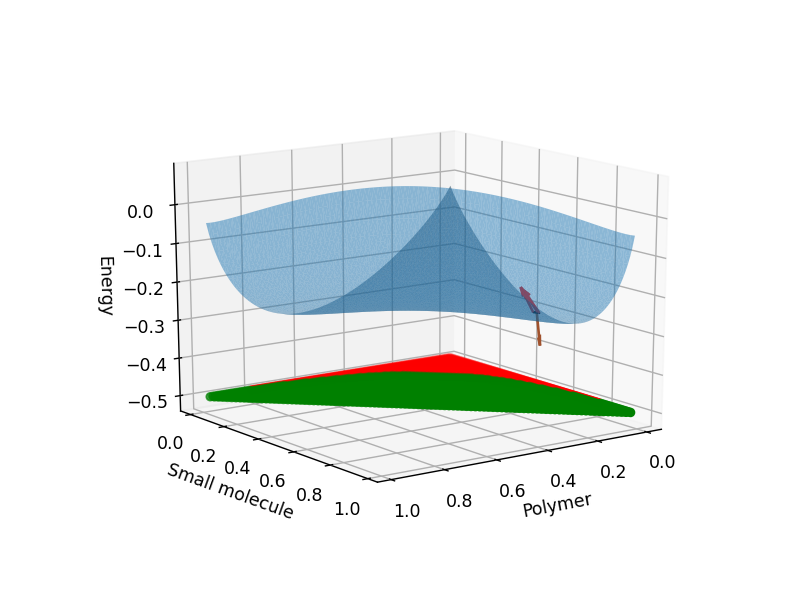

In [10]:
test_out = test.get_angles(use_findiff=False)
for key, value in test_out['thetas'].items():
    print('Angle at vertex {} is {:.2f} degrees'.format(key, value[2]))
fig = test.visualize()
plt.show()